# The standard incomplete markets model: Dynamics

By Thomas Mikaelsen, heavily based on Matt Rognlie's notebook https://conference.nber.org/confer/2022/MWs22/Lecture2.html

In [137]:
# Import steady state function from previous lecture and calculate steady state
include("Lecture1-Aiyagari.jl")
params = IncompleteMarketsParam()
ss = SteadyState(params);

In [29]:
# Assume all incomes increase by 1% at time 6
T = 11
ys = repeat(ss.y',11)
ys[6,:] = ys[6,:] * 1.01 

7-element Vector{Float64}:
 0.14278309254100494
 0.25286967817124456
 0.44783365453487006
 0.7931159780977797
 1.4046129591741494
 2.4875776299600996
 4.405514291080015

In [30]:
# Initial Va and containers 
Va = ss.Va
a = [zeros(7,500) for i in 1:T]
c = [zeros(7,500) for i in 1:T];
for t in T:-1:1
    Va, a[t], c[t] = EulerBack(Va, ss.P, ss.Agrid, ys[t,:], ss.r, ss.β, ss.σ)
end

In [65]:
@tullio c_impulse[i] := 100 .* (c[i] - ss.cpol) ./ ss.cpol;

In [68]:
c_impulse[1][1,i_ave]

0.03296541780052978

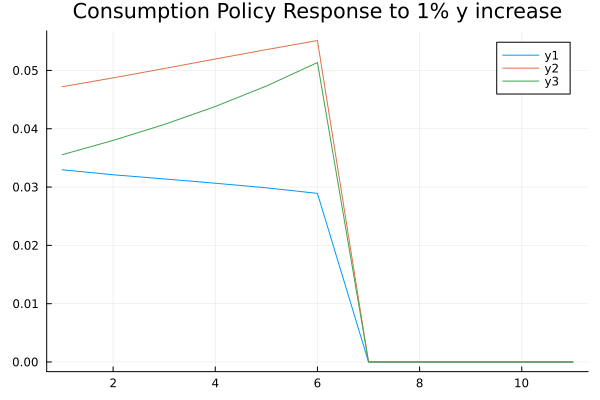

In [71]:
i_ave = searchsortedfirst(ss.Agrid, ss.A)
plt = plot([c_impulse[i][1,i_ave] for i in 1:11],title="Consumption Policy Response to 1% y increase")
for s in [4 7]
    plot!([c_impulse[i][s,i_ave] for i in 1:11])
end
plt

In [74]:
D = copy.(a)
D[1] = ss.D

7×500 Matrix{Float64}:
 0.0152463   2.00327e-5   1.40546e-5   …  3.35158e-126  2.0877e-128
 0.0886728   0.000246207  0.000174449     2.01179e-125  1.25316e-127
 0.201091    0.00137518   0.00098475      5.05763e-125  3.14984e-127
 0.185007    0.00355817   0.00260517      6.83594e-125  4.2551e-127
 0.00683405  0.000133803  9.79874e-5      5.26261e-125  3.2723e-127
 8.57025e-5  1.68817e-6   1.23637e-6   …  2.20333e-125  1.36745e-127
 3.59922e-7  7.11138e-9   5.2084e-9       3.9628e-126   2.45157e-128

In [82]:
for t in 1:T-1
    lottery = GetLottery.(a[t]; Agrid = ss.Agrid)
    D[t+1] = ForwardIteration(D[t], ss.P, lottery)
end

In [99]:
A, C = zeros(T), zeros(T)
for t in 1:T
    A[t] = sum(D[t] .* a[t])
    C[t] = sum(D[t] .* c[t])
end

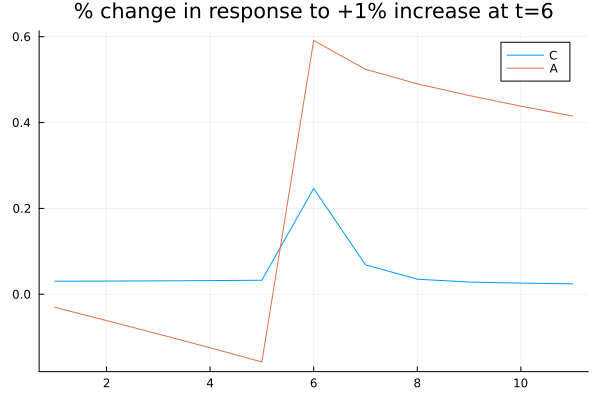

In [104]:
C_impulse = 100*(C .- ss.C) ./ ss.C
A_impulse = 100*(A .- ss.A) ./ ss.C
plt = plot(C_impulse, label = "C", title = "% change in response to +1% increase at t=6")
plot!(A_impulse, label = "A")

In [111]:
function yPolicyImpulse(ss, shocksize, shocktime, T)
    ns = length(ss.apol[:,1])
    na = length(ss.apol[1,:])
    Va = [zeros(ns,na) for i in 1:T]
    Va[T] = ss.Va
    a = [zeros(ns,na) for i in 1:T]
    c = [zeros(ns,na) for i in 1:T]
    ys = repeat(ss.y',T)
    ys[shocktime,:] = ys[shocktime,:] * (1 + shocksize) 
    for t in T:-1:1
        if t == T
            Va[t], a[t], c[t] = EulerBack(ss.Va, ss.P, ss.Agrid, ys[t,:], ss.r, ss.β, ss.σ)
        else 
            Va[t], a[t], c[t] = EulerBack(Va[t+1], ss.P, ss.Agrid, ys[t,:], ss.r, ss.β, ss.σ)
        end
    end
    return Va, a, c
end

yPolicyImpulse (generic function with 1 method)

In [113]:
Va_alt, a_alt, c_alt = yPolicyImpulse(ss, 0.01, 6, 11);

In [119]:
function yDistributionImpulse(ss, apol, T)
    D = copy.(apol)
    D[1] = ss.D
    
    for t in 1:T-1
        lottery = GetLottery.(apol[t]; Agrid = ss.Agrid)
        D[t+1] = ForwardIteration(D[t], ss.P, lottery)
    end
    return D
end

yDistributionImpulse (generic function with 1 method)

In [123]:
function yHouseholdImpulse(ss, shocksize, shocktime, T)
    Va, a, c = yPolicyImpulse(ss, shocksize, shocktime, T)
    D = yDistributionImpulse(ss, a, T)
    @tullio A[t] := sum(D[t] .* a[t])
    @tullio C[t] := sum(D[t] .* c[t])
    return (; Va = Va, a = a, c = c, D = D, A = A, C = C)
end

yHouseholdImpulse (generic function with 1 method)

In [124]:
y_impulse = yHouseholdImpulse(ss, 0.01, 6, 11);

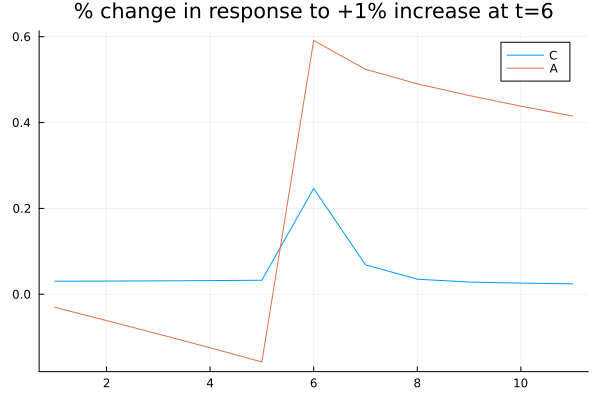

In [125]:
C_impulse = 100*(y_impulse.C .- ss.C) ./ ss.C
A_impulse = 100*(y_impulse.A .- ss.A) ./ ss.C
plt = plot(C_impulse, label = "C", title = "% change in response to +1% increase at t=6")
plot!(A_impulse, label = "A")

# GE impulse responses

In [142]:
B = 5.6
τ = ss.r*B
e = ss.y
function BetaCalibGE(Pi, Agrid, τ, e, r, σ, B)
    β_ge = find_zero(x ->  SteadyStateManual(Pi, Agrid, (1-τ)*e, r, x, σ).A - B, [0.98 0.995])    # Calibrate β to be consistentwith asset market clearing A = B
    ss_ge = SteadyStateManual(Pi, Agrid, (1-τ)*e, r, β_ge, σ)
    A_ge, C_ge = ss_ge.A, ss_ge.C

    if isapprox(C_ge, 1) == 1 & isapprox(A_ge, B) == 1
        println("Calibration succesful")
    else 
        println("Calibration unsuccesful")
    end
    return β_ge, ss_ge
end
β_ge, ss_ge = BetaCalibGE(ss.P, ss.Agrid, τ, e, ss.r, ss.σ, B)

Calibration succesful


(0.9877855433151642, (D = [0.013154814831448381 7.689818067204393e-5 … 7.7168841888515355e-106 5.5793897410306915e-108; 0.06927914923770942 0.0007790995471037031 … 4.690656131342102e-105 3.3896292162553254e-107; … ; 9.33359407479777e-7 2.756325652888306e-8 … 5.404355468777387e-105 3.882231665217495e-107; 2.9480944395898626e-9 8.716251258866142e-11 … 9.807517705803713e-106 7.019672945772212e-108], Va = [7.192039368548791 6.957948749685999 … 0.008370230408570841 0.007990758568292653; 4.060991535816445 3.9852834906360353 … 0.008361888098689749 0.007983154432472583; … ; 0.5995545731263092 0.599505120478301 … 0.00829448819348479 0.007921696245953317; 0.4293315112205243 0.4293121238990713 … 0.008259696740080275 0.007889955316918652], apol = [0.0 0.0 … 9440.931066238174 9899.6819644479; 0.0 0.0 … 9440.919047627522 9899.66993406864; … ; 0.756392229427214 0.7609438939984685 … 9442.126450025635 9900.877287824556; 1.9658033650564486 1.970387510091983 … 9443.489711766179 9902.240540153382], cpol =

In [143]:
# Persistent shock to TFP 
T = 300
Zs = [1 + 0.01*0.95^(t-1) for t in 1:T];

In [177]:
# TFP impulse functions: given a TFP sequence and a guess of rs, calculate policies for the period 1:T
function zPolicyImpulse(ss, rs, zs, T)
    # Productivity affects taxes through affecting r 
    taus = rs * 5.6
    # Productivity affects income through taxes
    @tullio ys[i] := (zs[i] - taus[i]) * ss.y 
    ns = length(ss.apol[:,1])
    na = length(ss.apol[1,:])
    Va = [zeros(ns,na) for i in 1:T]
    Va[T] = ss.Va
    a = [zeros(ns,na) for i in 1:T]
    c = [zeros(ns,na) for i in 1:T]
    for t in T:-1:1
        if t == T
            Va[t], a[t], c[t] = EulerBack(ss.Va, ss.P, ss.Agrid, ys[t], rs[t], ss.β, ss.σ)
        else 
            Va[t], a[t], c[t] = EulerBack(Va[t+1], ss.P, ss.Agrid, ys[t], rs[t], ss.β, ss.σ)
        end
    end
    return Va, a, c, taus, ys
end

zPolicyImpulse (generic function with 1 method)

In [203]:
Va_z, a_z, c_z, taus_z, ys_z = zPolicyImpulse(ss_ge, ss_ge.r*ones(T), Zs, T);

In [176]:
function zHouseholdImpulse(ss, rs, zs, T)
    Va, a, c, taus, ys = zPolicyImpulse(ss, rs, zs, T)
    # Same for y and z
    D = yDistributionImpulse(ss, a, T)
    @tullio A[t] := sum(D[t] .* a[t])
    @tullio C[t] := sum(D[t] .* c[t])
    return (; Va = Va, a = a, c = c, D = D, A = A, C = C, taus = taus, ys = ys)
end

zHouseholdImpulse (generic function with 1 method)

In [211]:
Va_z, a_z, c_z, D_z, A_z, C_z, taus_z, ys_z = zHouseholdImpulse(ss_ge,ss_ge.r*ones(T),Zs,T);

In [224]:
sum(D_z[50] .* a_z[50])

5.588964856432694

In [178]:
# Excess asset demand over supply given a TFP sequence and guess of r 
function zImpulseMap(ss, rs, zs, T)
    impulse = zHouseholdImpulse(ss, rs, zs, T)
    return impulse.A .- 5.6, impulse
end

zImpulseMap (generic function with 1 method)

In [186]:
# Assume r is constant
excess, impulse_z = zImpulseMap(ss_ge, ss_ge.r*ones(T), Zs, T);

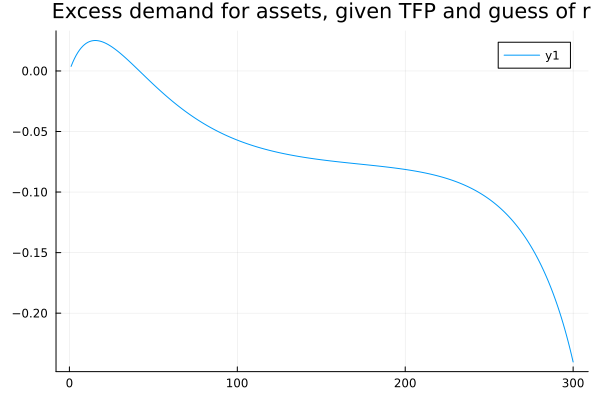

In [189]:
plot(excess, title = "Excess demand for assets, given TFP and guess of r")

# Trying the toolbox